In [63]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB6

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 528
BATCH_SIZE = 64

In [64]:
# Load the dataset

dataset_dir = "/home/clap/Documents/miniproject_bioinformatic/project/dataset_beans"
builder = tfds.ImageFolder(dataset_dir)
ds_train, ds_test, ds_val = builder.as_dataset(
    split=["train", "test", "validation"], as_supervised=True
)
ds_info = builder.info
NUM_CLASSES = builder.info.features["label"].num_classes


size = (IMG_SIZE, IMG_SIZE)
ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))

In [65]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

beansImages = {}
label_info = ds_info.features["label"]
for label_name in label_info.names:
    beansImages[label_name] = []
for i, (image, label) in enumerate(ds_train):
    beansImages[format_label(label)].append(image)
for label_name in label_info.names:
    print (f"Total of {label_name} leaves: {len(beansImages[label_name])}")

Total of angular_leaf_spot leaves: 345
Total of bean_rust leaves: 348
Total of healthy leaves: 341


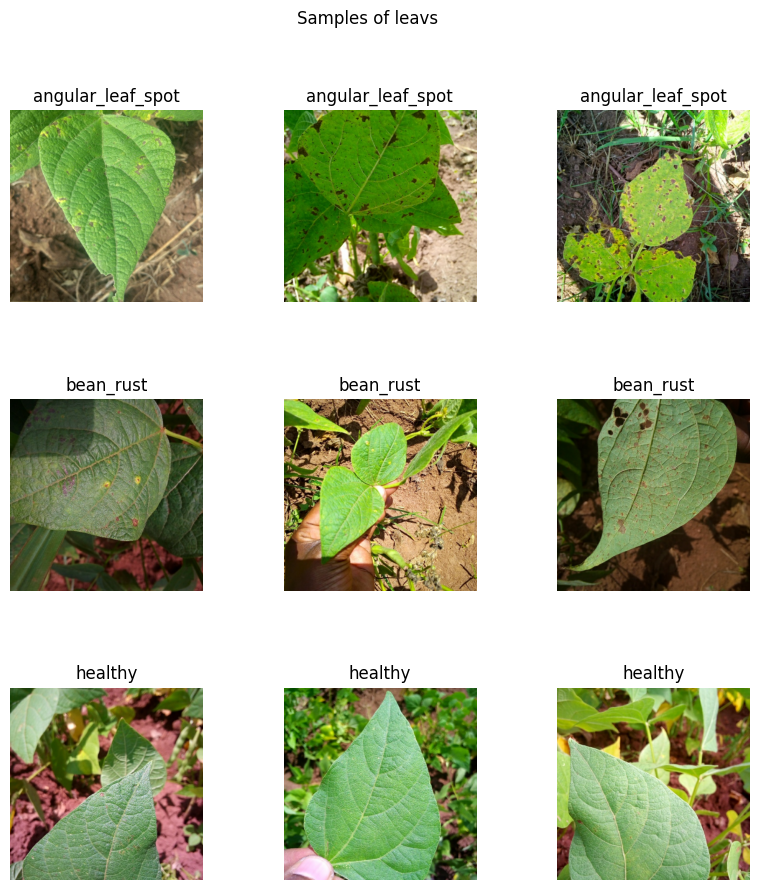

In [66]:
import random

def plot_sample_images():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Samples of leavs')
    for i, label in enumerate(beansImages.keys()):
        for j in range(3):
            randeom_index = random.randint(0, len(beansImages[label]) -1)	
            img = beansImages[label][randeom_index].numpy().astype("uint8")
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)
    plt.show()
plot_sample_images()

In [67]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.GaussianNoise(0.1)
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [68]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size=BATCH_SIZE, drop_remainder=True)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [69]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [70]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB6(include_top=False, input_tensor=inputs, weights="imagenet")
    
    # Freeze all layers initially
    base_model.trainable = False

    # Add classification head
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu", name="dense_before_output")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="dropout_before_output")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="EfficientNet")
    
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)  # Reduced learning rate
    model.compile(
        optimizer=optimizer, 
        loss="categorical_crossentropy", 
        metrics=["accuracy"]
    )

    return model

In [71]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_val)
# save the model 
modelName = 'models/all.keras'
model.save(modelName)


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 410s 25s/step - accuracy: 0.6394 - loss: 1.1778 - val_accuracy: 0.8594 - val_loss: 0.5394
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 397s 25s/step - accuracy: 0.8826 - loss: 0.3341 - val_accuracy: 0.8672 - val_loss: 0.5122
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.8991 - loss: 0.2605 - val_accuracy: 0.8047 - val_loss: 0.5182
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.9100 - loss: 0.2326 - val_accuracy: 0.8828 - val_loss: 0.4368
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.9257 - loss: 0.2063 - val_accuracy: 0.8594 - val_loss: 0.4689
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.9202 - loss: 0.2229 - val_accuracy: 0.8906 - val_loss: 0.4306
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.9209 - loss: 0.1985 - val_accuracy: 0.9375 - val_loss: 0.3497
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 396s 25s/step - accuracy: 0.9352 - loss: 0.1628 - val_accuracy: 0.

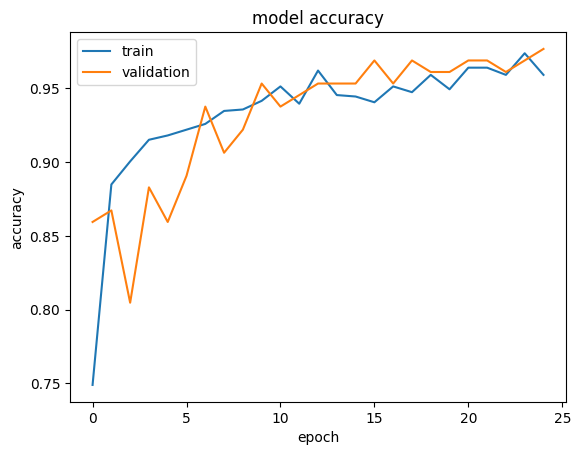

In [72]:
plot_hist(hist)

In [73]:
import cv2
import random

from tensorflow.keras.models import Model


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the model's output for the specified layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Get the last convolutional layer's output and model predictions
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the class channel with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the average of the gradients for each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps by the gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Apply ReLU to remove negative values, as we only care about positive influences
    heatmap = np.maximum(heatmap, 0)

    # Normalize to range [0, 1] for visualization
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


ANGULAR_LEAF_SPOT_INDEX = ds_info.features["label"].names.index("angular_leaf_spot")
last_conv_layer_name = "top_conv" 

heatmaps = []
original_images = []

# Iterate over the validation dataset
for images, labels in ds_val:
    for i in range(len(images)):
        # Check if the label matches "angular_leaf_spot"
        if tf.argmax(labels[i]) == ANGULAR_LEAF_SPOT_INDEX:
            original_images.append(images[i])
            # Prepare the image for Grad-CAM
            img_array = tf.expand_dims(images[i], axis=0)
            
            # Generate the Grad-CAM heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            heatmaps.append(heatmap)

            # Stop once we've collected 10 heatmaps
            if len(heatmaps) >= 10:
                break
    if len(heatmaps) >= 10:
        break

# for images, labels in ds_val.take(1):
#     # Select a single image from the batch
#     img = images[0]
#     img_array = tf.expand_dims(img, axis=0)  # Add batch dim

# last_conv_layer_name = "top_conv" 



# # Generate Grad-CAM heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
#plt.matshow(heatmap)
#plt.show()

/home/clap/Documents/www/beans-dataset-classification/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor_4119']]. Received: the structure of inputs=*
  warnings.warn(


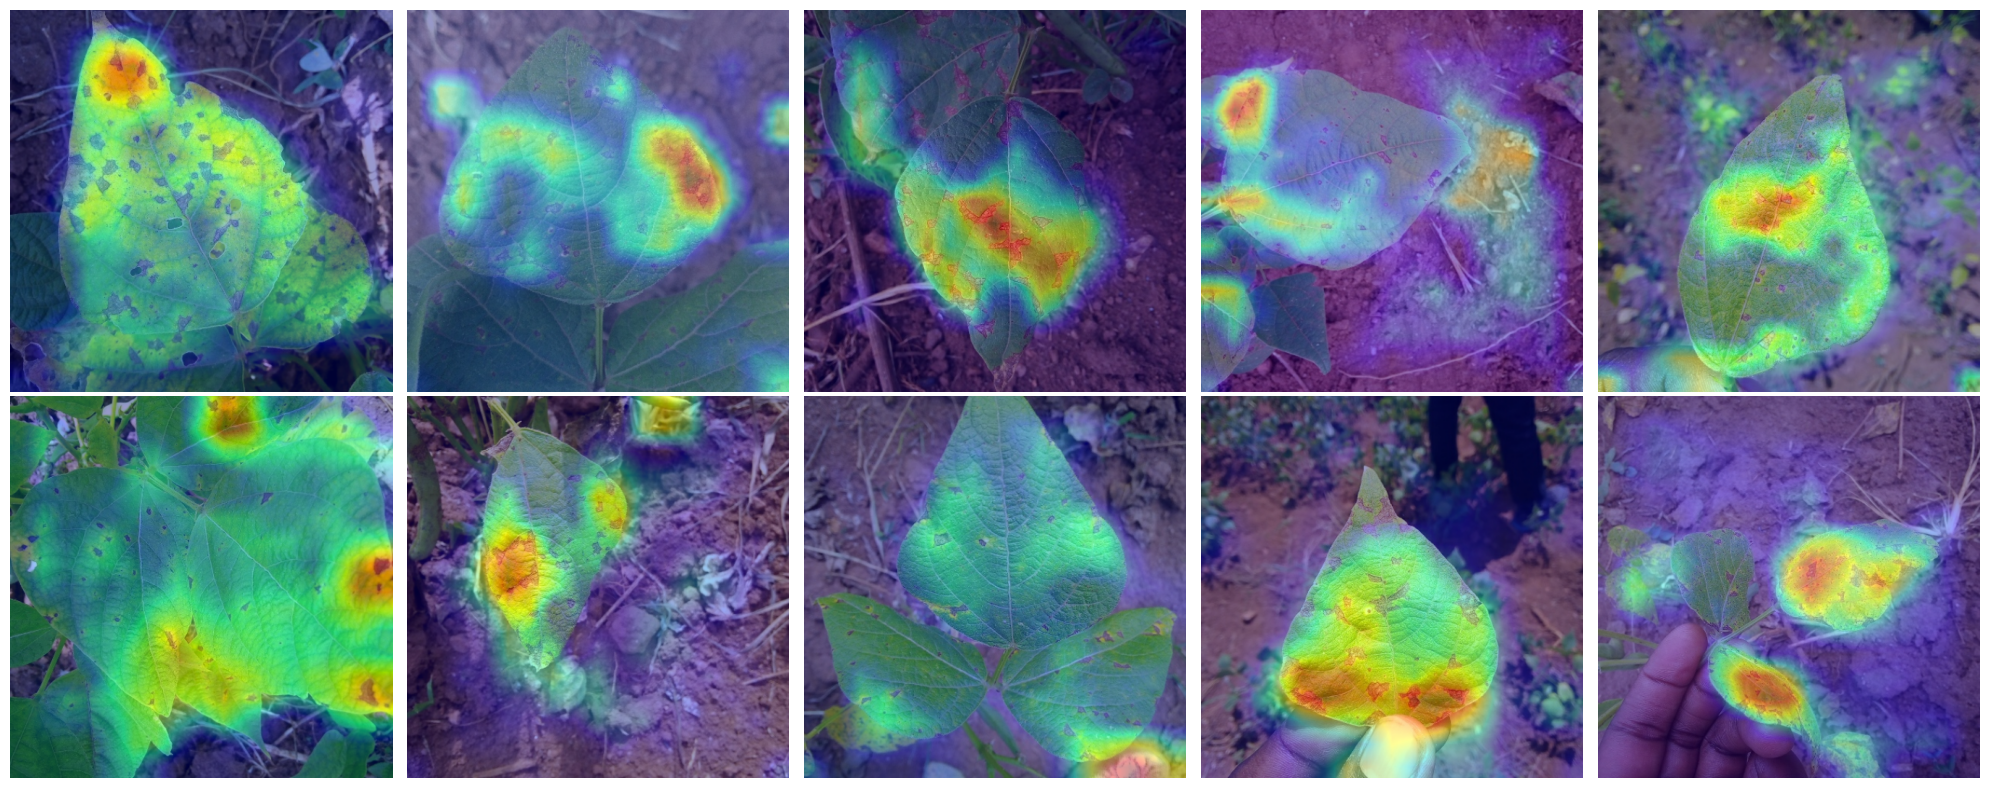

In [74]:
# Function to overlay the heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4):
    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to a color map (for visualization)
    heatmap = np.uint8(255 * heatmap)  # Scale to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Ensure both images are uint8
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if heatmap.dtype != np.uint8:
        heatmap = heatmap.astype(np.uint8)

    # Overlay the heatmap on the original image
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


# Assuming `heatmaps` contains the 10 Grad-CAM heatmaps and `images` contains the corresponding original images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, (heatmap, original_image) in enumerate(zip(heatmaps, original_images[:10])):
    # Preprocess original image for overlayimages
    original_image_np = original_image.numpy()  # Convert to NumPy array
    original_image_bgr = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)

    # Normalize the heatmap if not already done
    heatmap = np.maximum(heatmap, 0)  # Ensure no negative values
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]

    # Generate overlayed image
    overlayed_img = overlay_heatmap(heatmap, original_image_bgr)

    # Plot original image on the first row
    row, col = divmod(i, 5)  # Determine position in 2x5 grid
    axes[row, col].imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    axes[row, col].axis("off")


plt.tight_layout()
plt.show()
# Generate the overlayed image
    # Convert tensor to numpy array and prepare for overlay
# Ensure the heatmap is in the correct format (float and range [0, 1])
# heatmap = np.maximum(heatmap, 0)  # Ensure no negative values
# heatmap /= np.max(heatmap)  # Normalize to [0, 1]
# random_image_np = img.numpy()  # Convert to NumPy array
# original_image = cv2.cvtColor(random_image_np, cv2.COLOR_RGB2BGR) 
# overlayed_img = overlay_heatmap(heatmap, original_image)
# plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()

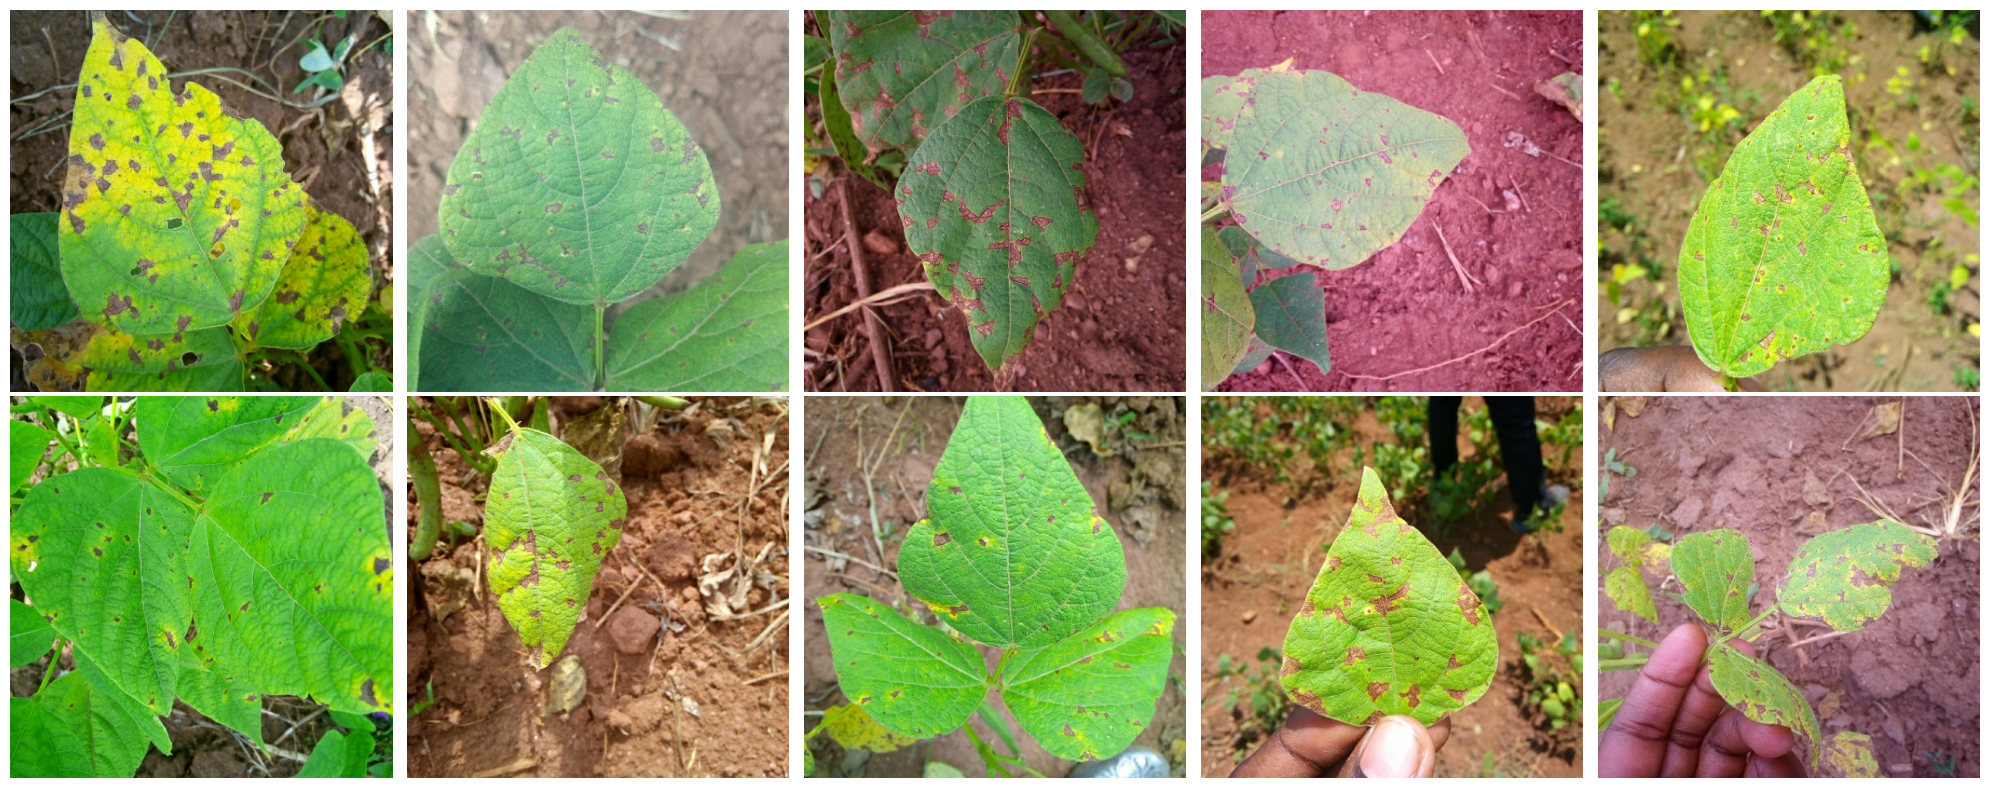

In [75]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, original_image in enumerate(original_images):
     original_image_np = original_image.numpy().astype("uint8")  # Convert to NumPy array
     row, col = divmod(i, 5)  # Determine position in 2x5 grid
     axes[row, col].imshow(original_image_np)
     axes[row, col].axis("off")

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 21s/step


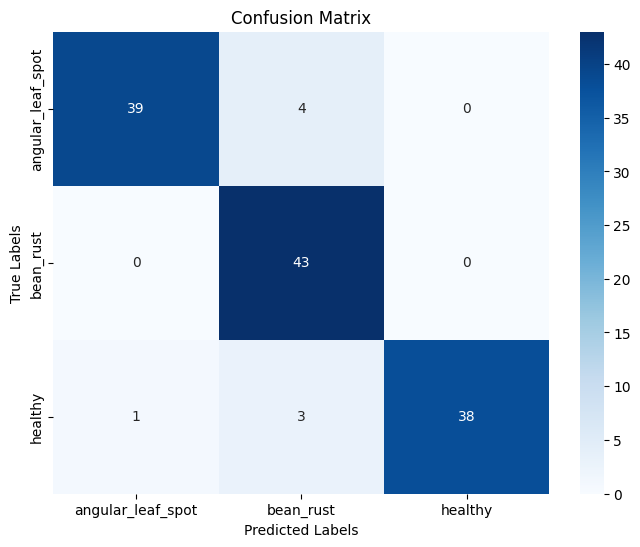

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Convert true labels to single-label format
true_labels = np.concatenate([np.argmax(y, axis=1) for x, y in ds_test], axis=0)

# Step 2: Get predicted labels (already handled with np.argmax)
predictions = model.predict(ds_test, batch_size=BATCH_SIZE)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_names = ds_info.features['label'].names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [77]:
from sklearn.metrics import classification_report
# Calculate accuracy
accuracy = np.mean(true_labels == predicted_labels)
print(f"Accuracy: {accuracy:.2f}")
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)

Accuracy: 0.94
                   precision    recall  f1-score   support

angular_leaf_spot       0.97      0.91      0.94        43
        bean_rust       0.86      1.00      0.92        43
          healthy       1.00      0.90      0.95        42

         accuracy                           0.94       128
        macro avg       0.94      0.94      0.94       128
     weighted avg       0.94      0.94      0.94       128

